In [3]:
# Add annotations:
# TODO promoters 3kb 0.053
# TODO STR constraint
# TODO common SVs in ASD, known ASD genes
# TODO eSTRs q<0.05 0.0046 cat /storage/mgymrek/gtex/causality/GTEx_merged_causality.tab | awk '($6<0.05)' | awk '{print $2 "\t" $3 "\t" $3+1}' | sed 's/^chr//' | sed 's/\.0//' | grep -v best | grep -v NA | intersectBed -a /storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/denovos_bylength.locus_summary.bed.gz -b stdin | awk '($6>0)' | uniq | datamash sum 8 sum 9 sum 13
# Top ones are promoters, AC dinucs

In [4]:
# scratch
#import scipy.stats
#t = 783123
#n11 = 2211
#n21 = 2104
#t = 26018
#n11 = 73
#n21 = 44
#n12 = t-n11
#n22 = t-n21
#table = [[n11, n12], [n21, n22]]
#scipy.stats.fisher_exact(table, alternative="greater")

(1.660945356435817, 0.0046309712487771163)

In [62]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os
import pandas as pd
import scipy.stats

# Params
PTHRESH=0.8
PCOLORS = {
    "ALL": "black",
    1: "gray",
    2: "red",
    3: "gold",
    4: "blue",
    5: "green",
    6: "purple"
}
PLABELS = {
    "ALL": "ALL",
    1: "Mono-",
    2: "Di-",
    3: "Tri-",
    4: "Tetra-",
    5: "Penta-",
    6: "Hexa-"
}

# Load data
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"
annot = pd.read_csv("/storage/mgymrek/ssc-denovos/denovos2/denovocalls/annotations/denovo_annotations.bed", sep="\t")
data = pd.read_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary.bed.gz"), sep="\t", usecols=range(18))
data = data[data["total_mutations"]>0]
data = pd.merge(data, annot, on=["start","end"])
for i in range(2, 7): # sfari cols include higher annotations
    data["sfari%s"%i] = data["sfari%s"%i] + data["sfari%s"%(i-1)]

Populating the interactive namespace from numpy and matplotlib


# Figure 3A QQ plot

In [6]:
def GetPermP(x):
    t = x["total_children"]
    if x["total_mutations"] == 0:
        n_aff = 0
        n_unaff = 0
    else:
        nsample = x["total_mutations"]
        n_aff = np.random.hypergeometric(t/2, t/2, nsample)
        n_unaff = nsample - n_aff
    n11 = n_aff
    n12 = t - n_aff
    n21 = n_unaff
    n22 = t - n21
    table = [[n11, n12], [n21, n22]]
    return scipy.stats.fisher_exact(table, alternative="greater")[1]
    
data["perm_p"] = data.apply(GetPermP, 1)

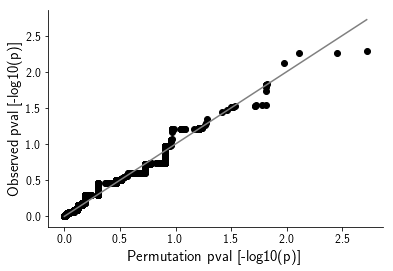

In [18]:
df = data
obs = [-1*np.log10(x) for x in sorted(list(df["p-value"]))]
exp = [-1*np.log10(x) for x in sorted(list(df["perm_p"]))]

maxval = max(obs + exp)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(exp, obs, color="black")
ax.plot([0,maxval],[0,maxval], color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Permutation pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);

# Figure 3B Enrichment by category

In [29]:
def GetASDEnrichment(df, printit=False):
    t = sum(df["total_children"])/2
    n11 = sum(df["affected_mutations"])
    n12 = t - n11
    n21 = sum(df["unaffected_mutations"])
    n22 = t - n21
    table = [[n11, n12], [n21, n22]]
    if printit:
        print(table)
    x = scipy.stats.fisher_exact(table, alternative="greater")
    return np.log2(x[0]), -1*np.log10(x[1])

In [15]:
motif_counts = data.groupby("motif", as_index=False).agg({"#chrom":len})
motif_counts.columns = ["motif","count"]
motif_counts = motif_counts.sort("count", ascending=False)
motifs = list(motif_counts[motif_counts["count"]>=100]["motif"].values)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [67]:
# Overall and by period
categories = ["ALL"]
odds, p = GetASDEnrichment(data)
pvals = [p]
enrichments = [odds]
colors = ["black"]
for period in range(1, 7):
    categories.append(PLABELS[period])
    odds, p = GetASDEnrichment(data[data["period"]==period])
    pvals.append(p)
    enrichments.append(odds)
    colors.append(PCOLORS[period])
# Transcribed
categories.append("Transcribed")
odds, p = GetASDEnrichment(data[data["gene"]!="."])
pvals.append(p)
enrichments.append(odds)
colors.append("white")
# STRCons Z TODO redo with new scores
categories.append("strconsZ")
odds, p = GetASDEnrichment(data[data.apply(lambda x: x["strconsZ"]!="." and float(x["strconsZ"])<0, 1)])
pvals.append(p)
enrichments.append(odds)
colors.append("cyan")

# Genomic region
for col in ["coding","3utr","5utr","promoter3kb","rnabp","tfbs","estrs","introns"]:
    categories.append(col)
    odds, p = GetASDEnrichment(data[data[col]>=1])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("white")

# SFARI gene score
for col in ["sfari1","sfari2","sfari3","sfari4","sfari5","sfari6","sfariS"]:
    categories.append(col)
    odds, p = GetASDEnrichment(data[data[col]>=1])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("purple")

# SFARI CNV
categories.append("SFARICNV")
odds, p = GetASDEnrichment(data[data["sfaricnv"]>=1])
pvals.append(p)
enrichments.append(odds)
colors.append("purple")

#for m in motifs:
#    categories.append(m)
#    odds, p = GetASDEnrichment(data[data["motif"]==m])
#    pvals.append(p)
#    enrichments.append(odds)
#    colors.append("brown")

for h in ['H3K27ac', 'H3K27me3','H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K79me2', 'H3K9ac','H4K20me1']:
    categories.append(h)
    odds, p = GetASDEnrichment(data[data[h]>=1])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("gold")
    
categories.append("donor")
odds, p = GetASDEnrichment(data[(data["donor"]>0) & (data["donor"]<500)])
pvals.append(p)
enrichments.append(odds)
colors.append("gold")

categories.append("acceptor")
odds, p = GetASDEnrichment(data[(data["acceptor"]<0) & (data["acceptor"]>-500)])
pvals.append(p)
enrichments.append(odds)
colors.append("gold")

/usr/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


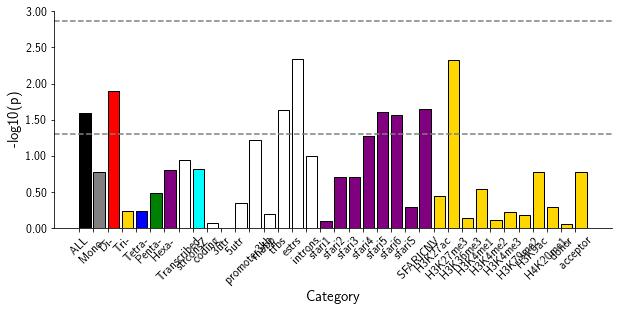

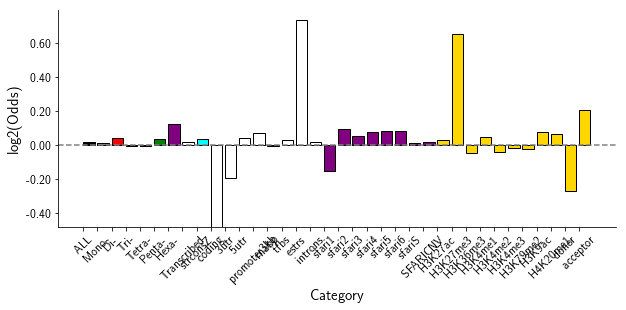

In [68]:
size = (10, 4)
fig = plt.figure()
fig.set_size_inches(size)
ax = fig.add_subplot(111)
ax.bar(range(len(categories)), pvals, color=colors, edgecolor="black", align="edge");
ax.axhline(-1*np.log10(0.05), color="gray", linestyle="dashed");
ax.axhline(-1*np.log10(0.05/len(categories)), color="gray", linestyle="dashed");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Category", size=15)
ax.set_ylabel("-log10(p)", size=15)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, size=12, rotation=45)
ax.set_yticklabels(["%0.2f"%x for x in ax.get_yticks()], size=12);
ax.legend(loc="upper right", frameon=False)

fig = plt.figure() 
fig.set_size_inches(size)
ax = fig.add_subplot(111)
ax.bar(range(len(categories)), enrichments, color=colors, edgecolor="black", align="edge");
ax.axhline(0, color="gray", linestyle="dashed");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Category", size=15)
ax.set_ylabel("log2(Odds)", size=15)
#ax.set_ylim(bottom=-0.25, top=-0.25)
#ax.set_yticks(np.arange(-0.25, 0.26, 0.05))
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, size=12, rotation=45)
ax.set_yticklabels(["%0.2f"%(x) for x in ax.get_yticks()], size=12);

In [66]:
edata = pd.DataFrame(
    {
        "category": categories,
        "pval": pvals,
        "enrich": enrichments
    }
)
edata.sort("pval", ascending=False)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,category,enrich,pval
15,estrs,0.732005,2.334328
26,H3K27me3,0.653342,2.324542
2,Di-,0.041510,1.895044
24,SFARICNV,0.019177,1.643259
14,tfbs,0.026435,1.632115
21,sfari5,0.082115,1.609440
0,ALL,0.018635,1.588982
22,sfari6,0.079840,1.567267
20,sfari4,0.074067,1.277170
12,promoter3kb,0.069031,1.214917
